# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [33]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook
raw_dir = '/Users/paramshah/Desktop/bootcamp/homework/stage07_outliers-risk-assumptions/data/raw'
processed_dir = '/Users/paramshah/Desktop/bootcamp/homework/stage07_outliers-risk-assumptions/data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

File already exists at /Users/paramshah/Desktop/bootcamp/homework/stage07_outliers-risk-assumptions/data/raw/outliers_homework.csv. Skipping CSV creation to avoid overwrite.


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

In [34]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(72)

## Load Data (provided or synthetic fallback)

In [35]:
data_path = Path('data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.000000,1.382255
1,0.050251,0.295081
2,0.100503,-1.428961
3,0.150754,2.039946
4,0.201005,3.451930


## TODO: Implement Outlier Functions (required)

In [36]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

*(Stretch)* Implement winsorizing (optional).

In [37]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

## Apply Detection and Create Flags (choose a numeric column)

In [38]:
target_col = 'y' if 'y' in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
wins = winsorize_series(df[target_col])
df['outlier_wins'] = df[target_col] != wins   # True if clipped
df[['outlier_iqr', 'outlier_z','outlier_wins']].mean()

outlier_iqr     0.005
outlier_z       0.005
outlier_wins    0.100
dtype: float64

In [39]:
df['y_wins'] = winsorize_series(df[target_col]) # fraction flagged

### Visual Checks (boxplot / histogram)

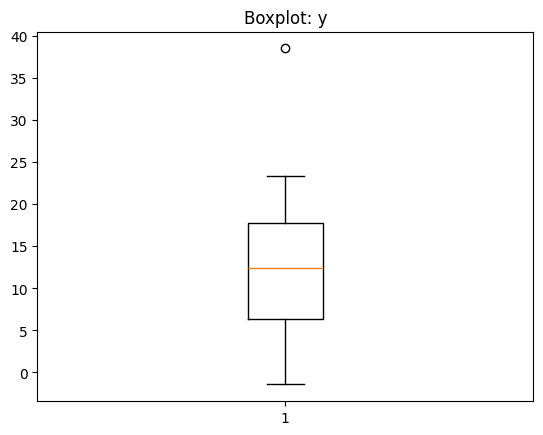

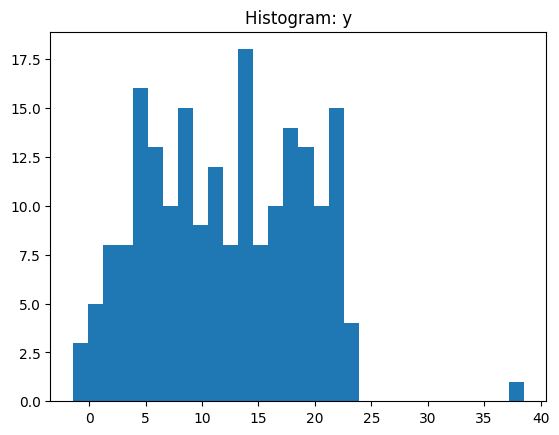

In [40]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [41]:
# Option A: Summary stats
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

,all,filtered_iqr,winsorized
mean,12.108612,11.975874,12.079536
median,12.452338,12.362018,12.452338
std,6.783349,6.534869,6.400801


## running regression tests

In [42]:
def run_regression(x, y):
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))
    return {
        "coef": model.coef_[0],
        "intercept": model.intercept_,
        "r2": r2_score(y, y_pred),
        "mae": mean_absolute_error(y, y_pred)
    }

results = {}

# Original
results["original"] = run_regression(df["x"].values, df["y"].values)

# IQR filtered
results["iqr_filtered"] = run_regression(
    df.loc[~df["outlier_iqr"], "x"].values,
    df.loc[~df["outlier_iqr"], "y"].values
)

# Winsorized
results["winsorized"] = run_regression(df["x"].values, df["y_wins"].values)

results_df = pd.DataFrame(results).T
results_df


,coef,intercept,r2,mae
original,2.177986,1.218683,0.872088,1.279517
iqr_filtered,2.141861,1.299293,0.908306,1.198343
winsorized,2.105877,1.550151,0.915664,1.139763


### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

## Reflection on Outliers, Assumptions, and Sensitivity Analysis

### Methods and Thresholds
For this analysis, I applied three approaches:
- **Baseline (all data):** No outlier treatment.
- **IQR filtering:** Outliers flagged using the interquartile range with *k = 1.5* and removed.
- **Winsorizing:** Values below the 5th percentile and above the 95th percentile were clipped.

The IQR method was chosen for its robustness to skewed distributions and minimal assumptions. Winsorizing was included as a compromise between keeping all observations and reducing the influence of extremes.

### Observed Impacts
**Summary statistics:**  
- The **mean** shifted only slightly across treatments (12.11 → 11.98 with IQR filtering → 12.08 with winsorizing).  
- The **median** remained almost identical, indicating that central tendency was stable.  
- The **standard deviation** decreased (6.78 → 6.53 → 6.40), showing that both filtering and winsorizing reduced variability.

**Regression results:**  
- The **slope (coef)** decreased from 2.18 (original) → 2.14 (IQR) → 2.11 (winsorized).  
- The **R²** improved with outlier handling (0.87 → 0.91), suggesting a tighter fit once extremes were controlled.  
- The **MAE** dropped (1.28 → 1.20 → 1.14), indicating better predictive accuracy after treatment.  
- Winsorizing gave the most stable results, reducing error while still retaining all data points.

### Assumptions
- I assumed that extreme values in the dataset were **not representative of the true process** (e.g., recording or sampling anomalies).  
- IQR assumes a distribution where quartiles are meaningful cutoffs.  
- Winsorizing assumes that clipping extremes provides a better estimate of central tendency without discarding information.

### Risks if Assumptions Are Wrong
- If the flagged points are actually **true rare events**, filtering or winsorizing could understate real variability and bias conclusions.  
- Using the IQR rule may misclassify outliers in **heavy-tailed or skewed distributions**.  
- Winsorizing hides outliers instead of addressing their cause, which may give a false sense of robustness.  
- Over-reliance on improved R² and MAE could lead to **overconfidence** in the model if important signals are mistakenly treated as noise.

### Conclusion
Outlier treatment in this dataset had **limited impact on central tendency** but **notable improvements in model fit and predictive accuracy**. This shows that while outliers did not distort the average much, they did meaningfully influence regression results. The balance between filtering (removing data) and winsorizing (transforming data) should be made carefully, depending on whether outliers are believed to be errors or genuine phenomena.
